<a href="https://colab.research.google.com/github/rira0526/dti0528/blob/main/unet_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
# Change to my working directory
!cd /gdrive/MyDrive

In [7]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.12.0


In [8]:
# Input image size that we are going to use
IMAGE_SIZE = 224
# ADE20k has 151 classes (background + 150 object) 
num_classes = 151
# Set batch size
batch = 2
# Set learning rate
LR = 1e-4
# Set epoch
EPOCHS = 5

In [20]:
# Set image and mask paths
image_path = "/gdrive/MyDrive/zikken3/multiclass segmentation/images/"
mask_path = "/gdrive/MyDrive/zikken3/multiclass segmentation/annotations/"
training_data = "training/"
val_data = "valtest/"

In [21]:
# Function to create lists of paths for training, validation and testing data
def load_data():

  TRAIN_X = sorted(glob(os.path.join(image_path + training_data, "*.png")))
  train_x = TRAIN_X[:5000]

  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.png")))
  train_y = TRAIN_Y[:5000]

  VALID_TEST_X = sorted(glob(os.path.join(image_path + val_data, "*.png")))
  valid_x = VALID_TEST_X[:165]

  VALID_TEST_Y = sorted(glob(os.path.join(mask_path + val_data, "*.png")))
  valid_y = VALID_TEST_Y[:165]

  test_x = VALID_TEST_X[165:400]
  test_y = VALID_TEST_Y[165:400]

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [22]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Test data: ", len(test_x))

Training data:  537
Validation data:  165
Test data:  130


In [23]:
# Set image augmentation (to be called by tensorflow dataset later)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(.5, .2),
  layers.experimental.preprocessing.RandomContrast(0.1)],
  )

In [24]:
# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

In [25]:
# Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    #dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

In [26]:
train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [27]:
# Function to load image/mask and convert colour space from BGR to RGB so that image/mask can be displayed correctly by matplotlib
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

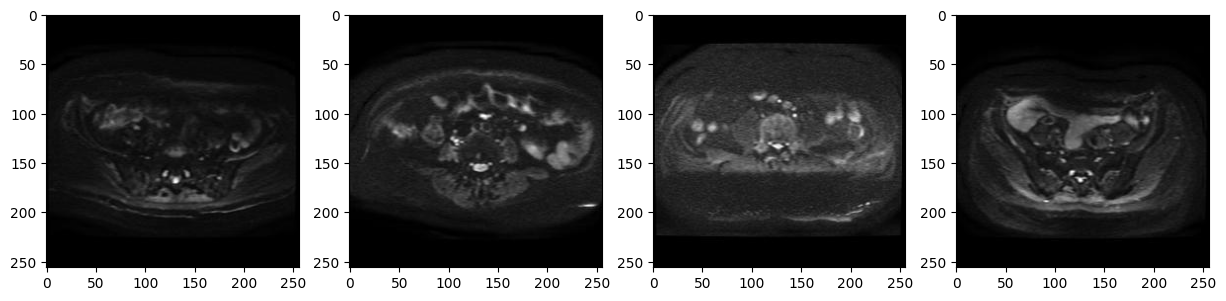

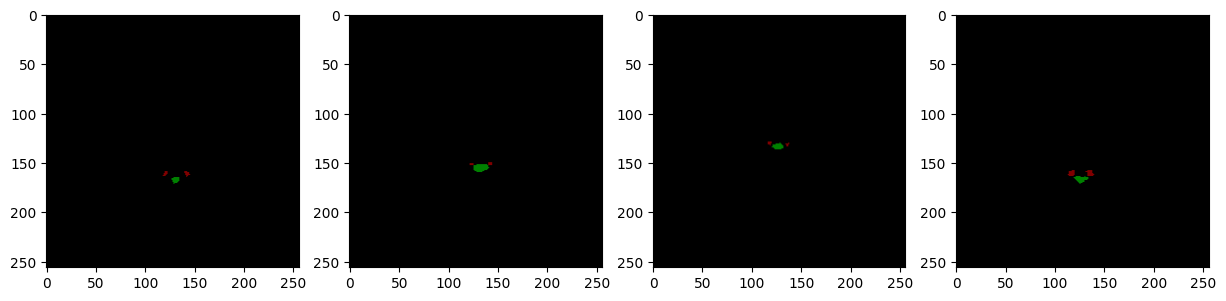

In [28]:
# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [29]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [30]:
# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [31]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=151)

17225924/17225924 [==============================] - 1s 0us/step


In [32]:
# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

In [33]:
# Freeze the encoder layers for transfer learning (so that weights are only changed for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f58900ce980> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5927e173d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f586e59f8b0> False
<keras.layers.activation.relu.ReLU object at 0x7f586e59f9a0> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f586e408bb0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f586e40a530> False
<keras.layers.activation.relu.ReLU object at 0x7f586e40b250> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f586e40b7f0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f586e4094b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f586e40b790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f586e465fc0> False
<keras.layers.activation.relu.ReLU object at 0x7f586e4670d0> False
<keras.layers.resha

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

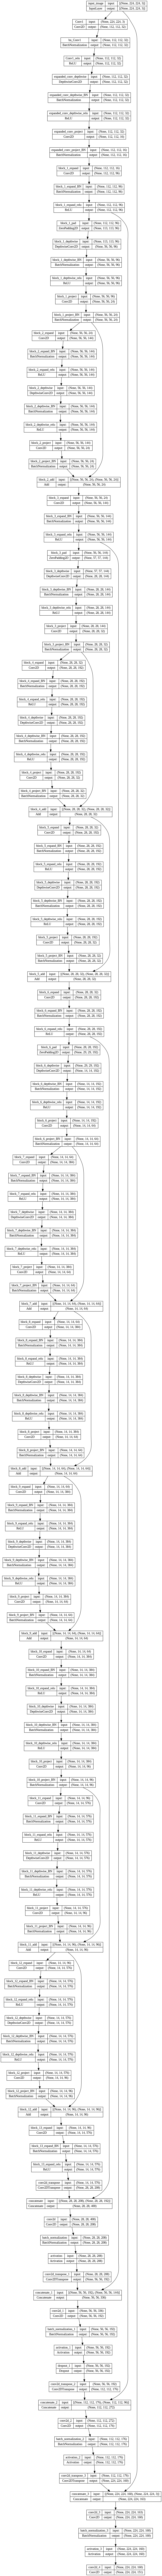

In [35]:
# Plot the unet model
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
# Functions for dice coefficient and dice loss 

import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=151)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [37]:
# Set up loss function, optimiser and complile the model 
opt = tf.keras.optimizers.Adam(LR)
metrics = [dice_coef, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
#model.compile(optimizer=opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [38]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2,   
    patience=2, 
    min_lr=0.00001,
)


In [39]:
# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = '/gdrive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [40]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1
if len(valid_x) % batch != 0: 
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=10,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
)


Epoch 1/10
269/269 [==============================] - ETA: 0s - loss: 0.9977 - dice_coef: 0.0023 - accuracy: 0.2425

269/269 [==============================] - 378s 1s/step - loss: 0.9977 - dice_coef: 0.0023 - accuracy: 0.2425 - val_loss: 0.9954 - val_dice_coef: 0.0046 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 2/10
269/269 [==============================] - ETA: 0s - loss: 0.9960 - dice_coef: 0.0040 - accuracy: 0.4956

269/269 [==============================] - 53s 195ms/step - loss: 0.9960 - dice_coef: 0.0040 - accuracy: 0.4956 - val_loss: 0.9939 - val_dice_coef: 0.0061 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 3/10
269/269 [==============================] - ETA: 0s - loss: 0.9943 - dice_coef: 0.0057 - accuracy: 0.5164

269/269 [==============================] - 51s 192ms/step - loss: 0.9943 - dice_coef: 0.0057 - accuracy: 0.5164 - val_loss: 0.9905 - val_dice_coef: 0.0095 - val_accuracy: 0.7135 - lr: 1.0000e-04
Epoch 4/10
269/269 [==============================] - ETA: 0s - loss: 0.9838 - dice_coef: 0.0162 - accuracy: 0.7897

269/269 [==============================] - 52s 192ms/step - loss: 0.9838 - dice_coef: 0.0162 - accuracy: 0.7897 - val_loss: 0.9268 - val_dice_coef: 0.0732 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 5/10
269/269 [==============================] - ETA: 0s - loss: 0.4598 - dice_coef: 0.5402 - accuracy: 0.9980

269/269 [==============================] - 53s 197ms/step - loss: 0.4598 - dice_coef: 0.5402 - accuracy: 0.9980 - val_loss: 0.4548 - val_dice_coef: 0.5452 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 6/10
269/269 [==============================] - 35s 132ms/step - loss: 0.4104 - dice_coef: 0.5896 - accuracy: 0.9982 - val_loss: 0.4632 - val_dice_coef: 0.5368 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 7/10
269/269 [==============================] - ETA: 0s - loss: 0.4005 - dice_coef: 0.5995 - accuracy: 0.9982

269/269 [==============================] - 54s 202ms/step - loss: 0.4005 - dice_coef: 0.5995 - accuracy: 0.9982 - val_loss: 0.4248 - val_dice_coef: 0.5752 - val_accuracy: 0.9976 - lr: 1.0000e-04
Epoch 8/10
269/269 [==============================] - 37s 137ms/step - loss: 0.3930 - dice_coef: 0.6070 - accuracy: 0.9983 - val_loss: 0.4568 - val_dice_coef: 0.5432 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 9/10
269/269 [==============================] - 37s 138ms/step - loss: 0.3848 - dice_coef: 0.6152 - accuracy: 0.9983 - val_loss: 0.4340 - val_dice_coef: 0.5660 - val_accuracy: 0.9976 - lr: 1.0000e-04
Epoch 10/10
269/269 [==============================] - 35s 131ms/step - loss: 0.3749 - dice_coef: 0.6251 - accuracy: 0.9983 - val_loss: 0.4352 - val_dice_coef: 0.5648 - val_accuracy: 0.9976 - lr: 2.0000e-05


In [41]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [42]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions():
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

1/1 [==============================] - 2s 2s/step


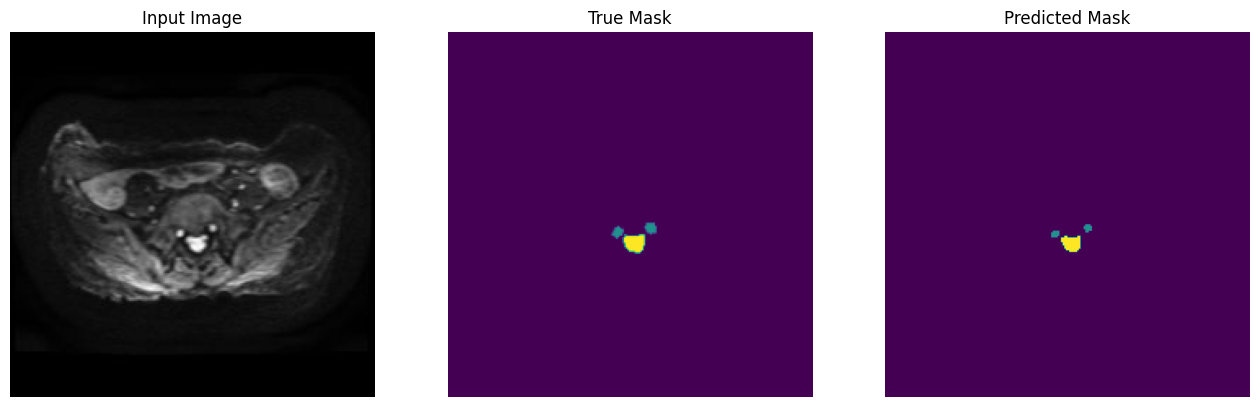

In [43]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask

show_predictions()

In [44]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0: 
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
dict(zip(model.metrics_names, result))

65/65 [==============================] - 92s 1s/step - loss: 0.4556 - dice_coef: 0.5444 - accuracy: 0.9977


{'loss': 0.4556007981300354,
 'dice_coef': 0.5443991422653198,
 'accuracy': 0.9977471828460693}